# Introduction

複数の時系列データの時系列予測を行います。


# 各種ライブラリの取得



In [20]:
%matplotlib inline 
import numpy as np
import pylab
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import sys
from matplotlib import animation as ani
import sklearn.metrics as mt
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, GRU, RepeatVector
from keras.layers.core import Dense, Lambda
from keras import objectives
from sklearn.preprocessing import MinMaxScaler
from copy import copy 
import time
from contextlib import contextmanager
import tensorflow as tf
from keras.callbacks import TensorBoard
from pathlib import Path

plt.style.use('ggplot')


# 時間計測のための関数

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.10f}s".format(title, time.time() - t0))

# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [3]:
wave_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])

In [4]:
max(wave_data["Temp"].values)

26.3

In [5]:
production_of_gas_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/monthly-production-of-gas-in-aus-train.csv', header=None, names=["Date", "production-of-gas"])
production_of_gas_data = production_of_gas_data.sort_values(by=['Date'])

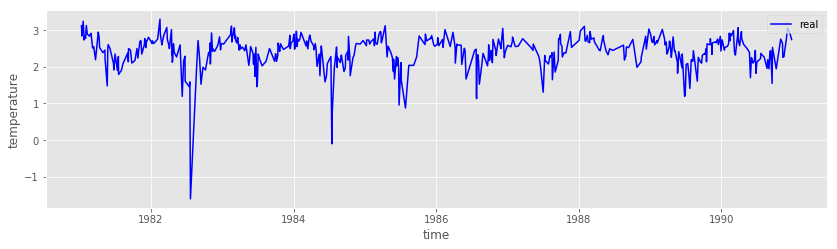

In [6]:
X_orig = np.nan_to_num(np.log(wave_data["Temp"].values + 1))
X_day = wave_data["Date"].values

def show_graph(day, data, label, color="b", ylabel='temperature'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph(X_day, X_orig, 'real')

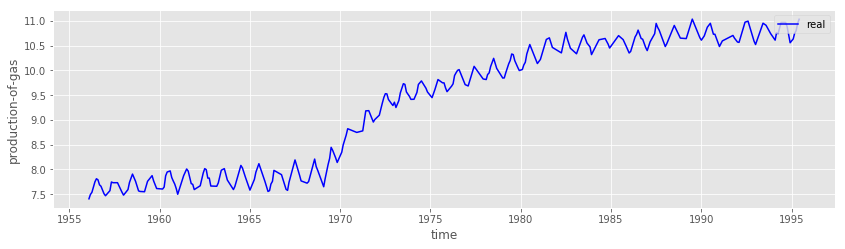

In [7]:
X_orig_second = np.nan_to_num(np.log(production_of_gas_data["production-of-gas"].values + 1))
X_day_second = production_of_gas_data["Date"].values

show_graph(X_day_second, X_orig_second, 'real', ylabel='production-of-gas')

In [8]:
print(X_orig_second.shape)
print(X_orig.shape)

(238,)
(500,)


# データの分割

- 学習データ
- テストデータ

In [54]:
X_train = X_orig[:150]
X_test = X_orig[151:238]
X_train_day = X_day[:150]
X_test_day = X_day[151:238]

X_train_second = X_orig_second[:150]
X_test_second = X_orig_second[151:238]
X_train_day_second = X_day_second[:150]
X_test_day_second = X_day_second[151:238]


# 学習データ

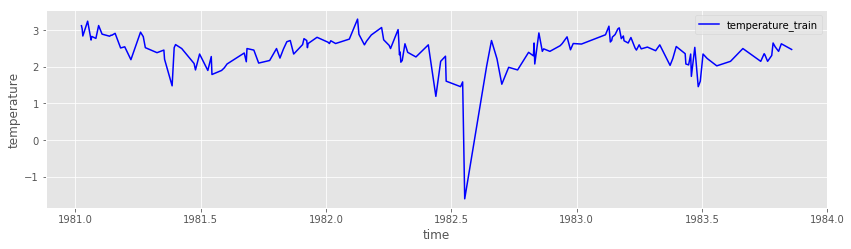

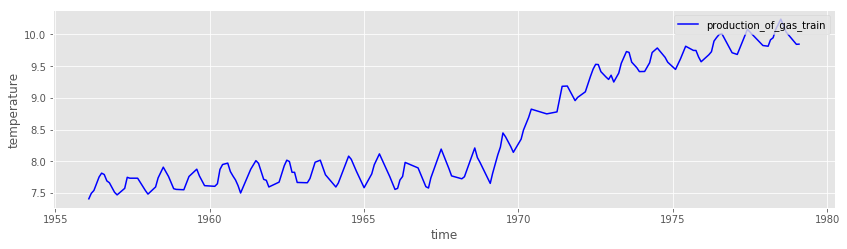

In [55]:
show_graph(X_train_day, X_train, 'temperature_train')
show_graph(X_train_day_second, X_train_second, 'production_of_gas_train')

# テストデータ

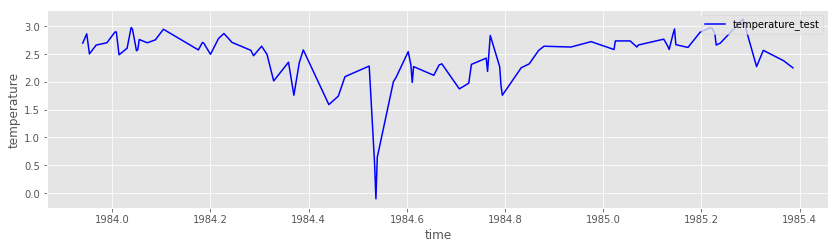

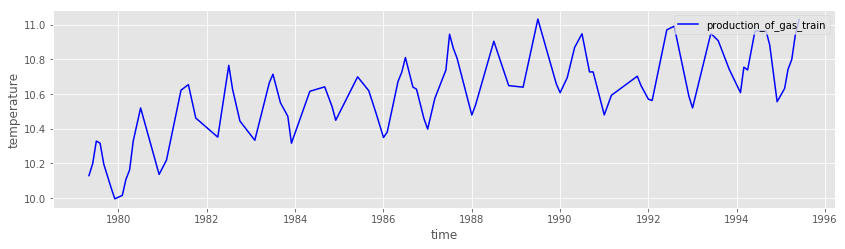

In [56]:
show_graph(X_test_day, X_test, 'temperature_test')
show_graph(X_test_day_second, X_test_second, 'production_of_gas_train')

# 前処理

- `get_data`: データを前処理して深層学習で扱える形に変換する
- `transform_data`: データを正規化して学習が容易な形に変更する。データを正規化後の値に戻して予測結果が適切か確認する

In [57]:
X_train_joint = np.vstack((X_train, X_train_second))
X_test_joint = np.vstack((X_test, X_test_second))

X_train_joint.shape

(2, 150)

In [58]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler

time_steps = 3
variable_number = 2

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)


input_dim = x.shape[-1]
timesteps = x.shape[1]
print(x.shape)
print('input_dim: ', input_dim)
print('timesteps: ', timesteps)

(2, 150)
(150, 2)
before max 3.126760535960395
Normalize
after max 0.3982653990092887
(2, 150)
(150, 3, 2)
input_dim:  2
timesteps:  3


# モデルの作成

- `create_model`でモデルを作成しています。指定できるのは
   - timestepsの幅
   - ノードの数
   - 自身の状態をリセットするかしないかを指定する`stateful`(周期的な波形は`True`の方が若干良くなります。)
   - `model_option`でGRUもしくはLSTMを選択できます。
   - `optimizer`で設定したい`optimizer`を指定できます。デファオルトでは`adam`が入っています。

In [59]:
def create_model(input_dim,
                 time_steps,
                 latent_dim,
                 # データが一つしかないので1しか選べない
                 batch_size=1,
                 model_option='lstm',
                 optimizer='adam',
                ):
    with tf.name_scope('Model'):
        x = Input(shape=(time_steps, input_dim,))

        if model_option == 'lstm':
            with tf.name_scope('LSTM'):
                h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
        elif model_option == 'gru':
            with tf.name_scope('GRU'):
                h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

        print('input_dim:', input_dim)
        with tf.name_scope('Dense'):
            out = Dense(input_dim)(h)

        model = Model(x, out)
        model.summary()

        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# 予測関数

In [60]:
def predict_model_show_graph(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[-1]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[:, 0, i], color='r', label='data')
        plt.plot(preds[:, 0, i], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(preds, prepare_value))
    return preds, prepare_value
    # return predict_scale, x_scale

# モデルの学習

In [61]:
predict_list = []
var_list = []

print(x.shape)
model = create_model(input_dim, 
                     time_steps=time_steps,
                     latent_dim=120,
                     model_option='lstm',
                    )


(150, 3, 2)
input_dim: 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3, 2)              0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 120)            59040     
_________________________________________________________________
dense_14 (Dense)             (None, 3, 2)              242       
Total params: 59,282
Trainable params: 59,282
Non-trainable params: 0
_________________________________________________________________


Epoch 1/400
150/150 [==============================] - 1s 3ms/step - loss: 0.3210 - mean_squared_error: 0.3210
Epoch 2/400
150/150 [==============================] - 0s 166us/step - loss: 0.2473 - mean_squared_error: 0.2473
Epoch 3/400
150/150 [==============================] - 0s 164us/step - loss: 0.1829 - mean_squared_error: 0.1829
Epoch 4/400
150/150 [==============================] - 0s 171us/step - loss: 0.1308 - mean_squared_error: 0.1308
Epoch 5/400
150/150 [==============================] - 0s 164us/step - loss: 0.0961 - mean_squared_error: 0.0961
Epoch 6/400
150/150 [==============================] - 0s 163us/step - loss: 0.0828 - mean_squared_error: 0.0828
Epoch 7/400
150/150 [==============================] - 0s 171us/step - loss: 0.0809 - mean_squared_error: 0.0809
Epoch 8/400
150/150 [==============================] - 0s 170us/step - loss: 0.0744 - mean_squared_error: 0.0744
Epoch 9/400
150/150 [==============================] - 0s 172us/step - loss: 0.0659 - mean_squared

Epoch 73/400
150/150 [==============================] - 0s 165us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 74/400
150/150 [==============================] - 0s 165us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 75/400
150/150 [==============================] - 0s 175us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 76/400
150/150 [==============================] - 0s 168us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 77/400
150/150 [==============================] - 0s 175us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 78/400
150/150 [==============================] - 0s 166us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 79/400
150/150 [==============================] - 0s 161us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 80/400
150/150 [==============================] - 0s 175us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 81/400
150/150 [==============================] - 0s 168us/step - loss: 0.0016 - m

150/150 [==============================] - 0s 156us/step - loss: 7.2090e-04 - mean_squared_error: 7.2090e-04
Epoch 143/400
150/150 [==============================] - 0s 169us/step - loss: 7.1545e-04 - mean_squared_error: 7.1545e-04
Epoch 144/400
150/150 [==============================] - 0s 166us/step - loss: 7.0773e-04 - mean_squared_error: 7.0773e-04
Epoch 145/400
150/150 [==============================] - 0s 172us/step - loss: 7.0175e-04 - mean_squared_error: 7.0175e-04
Epoch 146/400
150/150 [==============================] - 0s 189us/step - loss: 6.9591e-04 - mean_squared_error: 6.9591e-04
Epoch 147/400
150/150 [==============================] - 0s 178us/step - loss: 6.8859e-04 - mean_squared_error: 6.8859e-04
Epoch 148/400
150/150 [==============================] - 0s 164us/step - loss: 6.8236e-04 - mean_squared_error: 6.8236e-04
Epoch 149/400
150/150 [==============================] - 0s 154us/step - loss: 6.7612e-04 - mean_squared_error: 6.7612e-04
Epoch 150/400
150/150 [=======

150/150 [==============================] - 0s 162us/step - loss: 3.8809e-04 - mean_squared_error: 3.8809e-04
Epoch 209/400
150/150 [==============================] - 0s 165us/step - loss: 3.8452e-04 - mean_squared_error: 3.8452e-04
Epoch 210/400
150/150 [==============================] - 0s 158us/step - loss: 3.8007e-04 - mean_squared_error: 3.8007e-04
Epoch 211/400
150/150 [==============================] - 0s 192us/step - loss: 3.7636e-04 - mean_squared_error: 3.7636e-04
Epoch 212/400
150/150 [==============================] - 0s 182us/step - loss: 3.7271e-04 - mean_squared_error: 3.7271e-04
Epoch 213/400
150/150 [==============================] - 0s 194us/step - loss: 3.6925e-04 - mean_squared_error: 3.6925e-04
Epoch 214/400
150/150 [==============================] - 0s 176us/step - loss: 3.6695e-04 - mean_squared_error: 3.6695e-04
Epoch 215/400
150/150 [==============================] - 0s 172us/step - loss: 3.6230e-04 - mean_squared_error: 3.6230e-04
Epoch 216/400
150/150 [=======

150/150 [==============================] - 0s 159us/step - loss: 1.9004e-04 - mean_squared_error: 1.9004e-04
Epoch 275/400
150/150 [==============================] - 0s 162us/step - loss: 1.8785e-04 - mean_squared_error: 1.8785e-04
Epoch 276/400
150/150 [==============================] - 0s 167us/step - loss: 1.8562e-04 - mean_squared_error: 1.8562e-04
Epoch 277/400
150/150 [==============================] - 0s 164us/step - loss: 1.8297e-04 - mean_squared_error: 1.8297e-04
Epoch 278/400
150/150 [==============================] - 0s 167us/step - loss: 1.8106e-04 - mean_squared_error: 1.8106e-04
Epoch 279/400
150/150 [==============================] - 0s 160us/step - loss: 1.7938e-04 - mean_squared_error: 1.7938e-04
Epoch 280/400
150/150 [==============================] - 0s 180us/step - loss: 1.7751e-04 - mean_squared_error: 1.7751e-04
Epoch 281/400
150/150 [==============================] - 0s 194us/step - loss: 1.7453e-04 - mean_squared_error: 1.7453e-04
Epoch 282/400
150/150 [=======

150/150 [==============================] - 0s 156us/step - loss: 7.5114e-05 - mean_squared_error: 7.5114e-05
Epoch 341/400
150/150 [==============================] - 0s 157us/step - loss: 7.3999e-05 - mean_squared_error: 7.3999e-05
Epoch 342/400
150/150 [==============================] - 0s 152us/step - loss: 7.3380e-05 - mean_squared_error: 7.3380e-05
Epoch 343/400
150/150 [==============================] - 0s 145us/step - loss: 7.1926e-05 - mean_squared_error: 7.1926e-05
Epoch 344/400
150/150 [==============================] - 0s 153us/step - loss: 7.0330e-05 - mean_squared_error: 7.0330e-05
Epoch 345/400
150/150 [==============================] - 0s 161us/step - loss: 6.9574e-05 - mean_squared_error: 6.9574e-05
Epoch 346/400
150/150 [==============================] - 0s 159us/step - loss: 6.7958e-05 - mean_squared_error: 6.7958e-05
Epoch 347/400
150/150 [==============================] - 0s 169us/step - loss: 6.6976e-05 - mean_squared_error: 6.6976e-05
Epoch 348/400
150/150 [=======

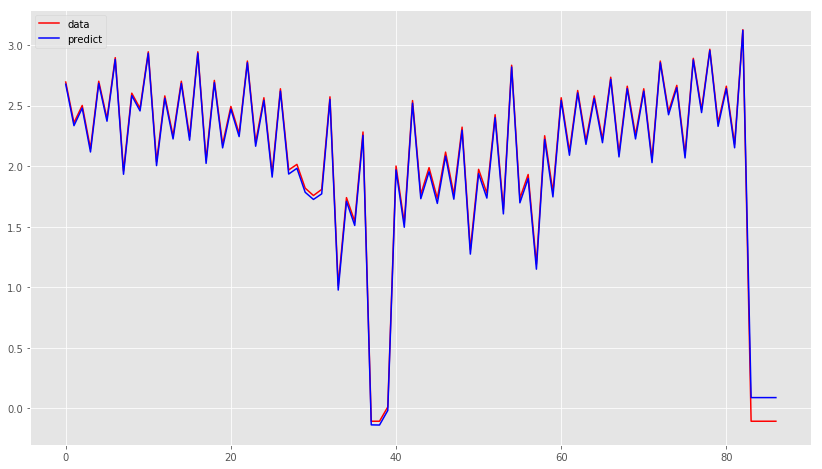

x_scale:  (87, 3, 2)


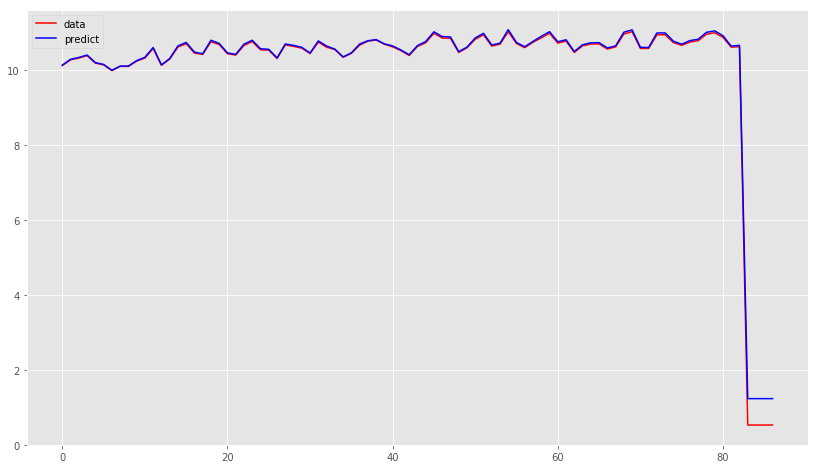

87/87 [==============================] - 1s 6ms/step
model evaluate mse: [1.1716788746844764, 1.1716788746844764]


In [62]:
log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )

with timer('train model simple'):
    model.fit(x, x, epochs=400, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

# RMSEを計算

In [63]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.03410091276360929
rmse: 0.09107017469006462
0.06258554372683696


# 個別入力型モデル

In [70]:
def create_model_individual(
     input_dim,
     time_steps,
     latent_dim_list,
     # データが一つしかないので1しか選べない
     batch_size=1,
     model_option='lstm',
     optimizer='adam',
):
    input_list = []
    output_list = []
    
    with tf.name_scope('Model'):
        for i in range(input_dim):
            with tf.name_scope('Input' + str(i)):    
                x = Input(shape=(time_steps, 1,))

            if model_option == 'lstm':
                with tf.name_scope('LSTM' + str(i)):
                    h = LSTM(latent_dim_list[i], stateful=False, return_sequences=True)(x)
            elif model_option == 'gru':
                with tf.name_scope('GRU' + str(i)):
                    h = GRU(latent_dim_list[i], stateful=False, return_sequences=True)(x)
            
            with tf.name_scope('Dense' + str(i)):
                out = Dense(1)(h)
            input_list.append(x)
            output_list.append(out)

        model = Model(inputs=input_list, outputs=output_list)
        model.summary()
        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# 個別入力型のためのデータ準備

In [71]:
def prepare_data_individual(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x_reshape = []
    for i in range(x.shape[0]):
        x_reshape.append([x[i]])
    x_reshape = np.array(x_reshape)
    x_reshape = np.swapaxes(x_reshape, 1, 2)
    x_reshape = np.swapaxes(x_reshape, 2, 3)
    return list(x_reshape), scaler
   

x, scaler = prepare_data_individual(X_train_joint, time_steps, variable_number)
print(len(x))

(2, 150)
(150, 2)
before max 3.126760535960395
Normalize
after max 0.3982653990092887
(2, 150)
2


# 個別入力型モデルの予測関数

In [72]:
def predict_model_show_graph_individual(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    prepare_value = np.array(prepare_value)
    preds = np.array(preds)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[0]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[i, :, 0, 0], color='r', label='data')
        plt.plot(preds[i, :, 0, 0], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(list(preds), list(prepare_value)))
    return preds, prepare_value
    # return predict_scale, x_scale

# 個別入力モデルの定義

In [73]:
predict_list = []
var_list = []

model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_17 (LSTM)                  (None, 3, 120)       58560       input_17[0][0]                   
__________________________________________________________________________________________________
lstm_18 (LSTM)                  (None, 3, 150)       91200       input_18[0][0]                   
__________________________________________________________________________________________________
dense_17 (

# 個別入力モデルの学習

Epoch 1/400
150/150 [==============================] - 1s 6ms/step - loss: 0.7434 - dense_17_loss: 0.0684 - dense_18_loss: 0.6750 - dense_17_mean_squared_error: 0.0684 - dense_18_mean_squared_error: 0.6750
Epoch 2/400
150/150 [==============================] - 0s 227us/step - loss: 0.5646 - dense_17_loss: 0.0478 - dense_18_loss: 0.5168 - dense_17_mean_squared_error: 0.0478 - dense_18_mean_squared_error: 0.5168
Epoch 3/400
150/150 [==============================] - 0s 232us/step - loss: 0.4149 - dense_17_loss: 0.0332 - dense_18_loss: 0.3818 - dense_17_mean_squared_error: 0.0332 - dense_18_mean_squared_error: 0.3818
Epoch 4/400
150/150 [==============================] - 0s 257us/step - loss: 0.2932 - dense_17_loss: 0.0247 - dense_18_loss: 0.2685 - dense_17_mean_squared_error: 0.0247 - dense_18_mean_squared_error: 0.2685
Epoch 5/400
150/150 [==============================] - 0s 245us/step - loss: 0.2116 - dense_17_loss: 0.0223 - dense_18_loss: 0.1893 - dense_17_mean_squared_error: 0.0223 

150/150 [==============================] - 0s 259us/step - loss: 0.0071 - dense_17_loss: 0.0025 - dense_18_loss: 0.0046 - dense_17_mean_squared_error: 0.0025 - dense_18_mean_squared_error: 0.0046
Epoch 41/400
150/150 [==============================] - 0s 241us/step - loss: 0.0068 - dense_17_loss: 0.0023 - dense_18_loss: 0.0045 - dense_17_mean_squared_error: 0.0023 - dense_18_mean_squared_error: 0.0045
Epoch 42/400
150/150 [==============================] - 0s 240us/step - loss: 0.0065 - dense_17_loss: 0.0021 - dense_18_loss: 0.0044 - dense_17_mean_squared_error: 0.0021 - dense_18_mean_squared_error: 0.0044
Epoch 43/400
150/150 [==============================] - 0s 232us/step - loss: 0.0062 - dense_17_loss: 0.0019 - dense_18_loss: 0.0043 - dense_17_mean_squared_error: 0.0019 - dense_18_mean_squared_error: 0.0043
Epoch 44/400
150/150 [==============================] - 0s 259us/step - loss: 0.0060 - dense_17_loss: 0.0018 - dense_18_loss: 0.0042 - dense_17_mean_squared_error: 0.0018 - dens

150/150 [==============================] - 0s 224us/step - loss: 0.0027 - dense_17_loss: 8.6024e-05 - dense_18_loss: 0.0026 - dense_17_mean_squared_error: 8.6024e-05 - dense_18_mean_squared_error: 0.0026
Epoch 79/400
150/150 [==============================] - 0s 238us/step - loss: 0.0026 - dense_17_loss: 7.8701e-05 - dense_18_loss: 0.0025 - dense_17_mean_squared_error: 7.8701e-05 - dense_18_mean_squared_error: 0.0025
Epoch 80/400
150/150 [==============================] - 0s 242us/step - loss: 0.0026 - dense_17_loss: 7.2263e-05 - dense_18_loss: 0.0025 - dense_17_mean_squared_error: 7.2263e-05 - dense_18_mean_squared_error: 0.0025
Epoch 81/400
150/150 [==============================] - 0s 234us/step - loss: 0.0026 - dense_17_loss: 6.6740e-05 - dense_18_loss: 0.0025 - dense_17_mean_squared_error: 6.6740e-05 - dense_18_mean_squared_error: 0.0025
Epoch 82/400
150/150 [==============================] - 0s 241us/step - loss: 0.0025 - dense_17_loss: 6.1621e-05 - dense_18_loss: 0.0025 - dense_

150/150 [==============================] - 0s 229us/step - loss: 0.0019 - dense_17_loss: 1.0723e-05 - dense_18_loss: 0.0019 - dense_17_mean_squared_error: 1.0723e-05 - dense_18_mean_squared_error: 0.0019
Epoch 116/400
150/150 [==============================] - 0s 241us/step - loss: 0.0019 - dense_17_loss: 1.0408e-05 - dense_18_loss: 0.0019 - dense_17_mean_squared_error: 1.0408e-05 - dense_18_mean_squared_error: 0.0019      
Epoch 117/400
150/150 [==============================] - 0s 243us/step - loss: 0.0019 - dense_17_loss: 1.0042e-05 - dense_18_loss: 0.0019 - dense_17_mean_squared_error: 1.0042e-05 - dense_18_mean_squared_error: 0.0019
Epoch 118/400
150/150 [==============================] - 0s 247us/step - loss: 0.0019 - dense_17_loss: 9.7239e-06 - dense_18_loss: 0.0019 - dense_17_mean_squared_error: 9.7239e-06 - dense_18_mean_squared_error: 0.0019
Epoch 119/400
150/150 [==============================] - 0s 232us/step - loss: 0.0019 - dense_17_loss: 9.4209e-06 - dense_18_loss: 0.001

150/150 [==============================] - 0s 260us/step - loss: 0.0014 - dense_17_loss: 5.1807e-06 - dense_18_loss: 0.0014 - dense_17_mean_squared_error: 5.1807e-06 - dense_18_mean_squared_error: 0.0014
Epoch 153/400
150/150 [==============================] - 0s 261us/step - loss: 0.0014 - dense_17_loss: 5.1381e-06 - dense_18_loss: 0.0014 - dense_17_mean_squared_error: 5.1381e-06 - dense_18_mean_squared_error: 0.0014      
Epoch 154/400
150/150 [==============================] - 0s 281us/step - loss: 0.0013 - dense_17_loss: 5.0947e-06 - dense_18_loss: 0.0013 - dense_17_mean_squared_error: 5.0947e-06 - dense_18_mean_squared_error: 0.0013
Epoch 155/400
150/150 [==============================] - 0s 257us/step - loss: 0.0013 - dense_17_loss: 5.0621e-06 - dense_18_loss: 0.0013 - dense_17_mean_squared_error: 5.0621e-06 - dense_18_mean_squared_error: 0.0013
Epoch 156/400
150/150 [==============================] - 0s 265us/step - loss: 0.0013 - dense_17_loss: 5.0336e-06 - dense_18_loss: 0.001

150/150 [==============================] - 0s 274us/step - loss: 8.9865e-04 - dense_17_loss: 4.4239e-06 - dense_18_loss: 8.9423e-04 - dense_17_mean_squared_error: 4.4239e-06 - dense_18_mean_squared_error: 8.9423e-04
Epoch 189/400
150/150 [==============================] - 0s 275us/step - loss: 8.8603e-04 - dense_17_loss: 4.3876e-06 - dense_18_loss: 8.8164e-04 - dense_17_mean_squared_error: 4.3876e-06 - dense_18_mean_squared_error: 8.8164e-04
Epoch 190/400
150/150 [==============================] - 0s 287us/step - loss: 8.7431e-04 - dense_17_loss: 4.3728e-06 - dense_18_loss: 8.6993e-04 - dense_17_mean_squared_error: 4.3728e-06 - dense_18_mean_squared_error: 8.6993e-04
Epoch 191/400
150/150 [==============================] - 0s 241us/step - loss: 8.6232e-04 - dense_17_loss: 4.3570e-06 - dense_18_loss: 8.5797e-04 - dense_17_mean_squared_error: 4.3570e-06 - dense_18_mean_squared_error: 8.5797e-04
Epoch 192/400
150/150 [==============================] - 0s 247us/step - loss: 8.5273e-04 - de

150/150 [==============================] - 0s 213us/step - loss: 5.0281e-04 - dense_17_loss: 3.9303e-06 - dense_18_loss: 4.9888e-04 - dense_17_mean_squared_error: 3.9303e-06 - dense_18_mean_squared_error: 4.9888e-04
Epoch 224/400
150/150 [==============================] - 0s 206us/step - loss: 4.9172e-04 - dense_17_loss: 3.9081e-06 - dense_18_loss: 4.8781e-04 - dense_17_mean_squared_error: 3.9081e-06 - dense_18_mean_squared_error: 4.8781e-04
Epoch 225/400
150/150 [==============================] - 0s 216us/step - loss: 4.8439e-04 - dense_17_loss: 3.9014e-06 - dense_18_loss: 4.8049e-04 - dense_17_mean_squared_error: 3.9014e-06 - dense_18_mean_squared_error: 4.8049e-04
Epoch 226/400
150/150 [==============================] - 0s 209us/step - loss: 4.7290e-04 - dense_17_loss: 3.8844e-06 - dense_18_loss: 4.6901e-04 - dense_17_mean_squared_error: 3.8844e-06 - dense_18_mean_squared_error: 4.6901e-04
Epoch 227/400
150/150 [==============================] - 0s 230us/step - loss: 4.6364e-04 - de

150/150 [==============================] - 0s 230us/step - loss: 2.3482e-04 - dense_17_loss: 3.4999e-06 - dense_18_loss: 2.3132e-04 - dense_17_mean_squared_error: 3.4999e-06 - dense_18_mean_squared_error: 2.3132e-04
Epoch 259/400
150/150 [==============================] - 0s 239us/step - loss: 2.2910e-04 - dense_17_loss: 3.5170e-06 - dense_18_loss: 2.2559e-04 - dense_17_mean_squared_error: 3.5170e-06 - dense_18_mean_squared_error: 2.2559e-04
Epoch 260/400
150/150 [==============================] - 0s 232us/step - loss: 2.2474e-04 - dense_17_loss: 3.4896e-06 - dense_18_loss: 2.2125e-04 - dense_17_mean_squared_error: 3.4896e-06 - dense_18_mean_squared_error: 2.2125e-04
Epoch 261/400
150/150 [==============================] - 0s 237us/step - loss: 2.1954e-04 - dense_17_loss: 3.4762e-06 - dense_18_loss: 2.1606e-04 - dense_17_mean_squared_error: 3.4762e-06 - dense_18_mean_squared_error: 2.1606e-04
Epoch 262/400
150/150 [==============================] - 0s 226us/step - loss: 2.1472e-04 - de

150/150 [==============================] - 0s 235us/step - loss: 1.1205e-04 - dense_17_loss: 3.1303e-06 - dense_18_loss: 1.0892e-04 - dense_17_mean_squared_error: 3.1303e-06 - dense_18_mean_squared_error: 1.0892e-04
Epoch 294/400
150/150 [==============================] - 0s 235us/step - loss: 1.0915e-04 - dense_17_loss: 3.1117e-06 - dense_18_loss: 1.0604e-04 - dense_17_mean_squared_error: 3.1117e-06 - dense_18_mean_squared_error: 1.0604e-04
Epoch 295/400
150/150 [==============================] - 0s 227us/step - loss: 1.0743e-04 - dense_17_loss: 3.0879e-06 - dense_18_loss: 1.0434e-04 - dense_17_mean_squared_error: 3.0879e-06 - dense_18_mean_squared_error: 1.0434e-04
Epoch 296/400
150/150 [==============================] - 0s 220us/step - loss: 1.0564e-04 - dense_17_loss: 3.0822e-06 - dense_18_loss: 1.0256e-04 - dense_17_mean_squared_error: 3.0822e-06 - dense_18_mean_squared_error: 1.0256e-04
Epoch 297/400
150/150 [==============================] - 0s 237us/step - loss: 1.0364e-04 - de

150/150 [==============================] - 0s 252us/step - loss: 5.9891e-05 - dense_17_loss: 2.7703e-06 - dense_18_loss: 5.7121e-05 - dense_17_mean_squared_error: 2.7703e-06 - dense_18_mean_squared_error: 5.7121e-05
Epoch 329/400
150/150 [==============================] - 0s 267us/step - loss: 5.8871e-05 - dense_17_loss: 2.7565e-06 - dense_18_loss: 5.6114e-05 - dense_17_mean_squared_error: 2.7565e-06 - dense_18_mean_squared_error: 5.6114e-05
Epoch 330/400
150/150 [==============================] - 0s 296us/step - loss: 5.8137e-05 - dense_17_loss: 2.7771e-06 - dense_18_loss: 5.5360e-05 - dense_17_mean_squared_error: 2.7771e-06 - dense_18_mean_squared_error: 5.5360e-05
Epoch 331/400
150/150 [==============================] - 0s 278us/step - loss: 5.7468e-05 - dense_17_loss: 2.7575e-06 - dense_18_loss: 5.4710e-05 - dense_17_mean_squared_error: 2.7575e-06 - dense_18_mean_squared_error: 5.4710e-05
Epoch 332/400
150/150 [==============================] - 0s 270us/step - loss: 5.6302e-05 - de

150/150 [==============================] - 0s 239us/step - loss: 3.8240e-05 - dense_17_loss: 2.4588e-06 - dense_18_loss: 3.5781e-05 - dense_17_mean_squared_error: 2.4588e-06 - dense_18_mean_squared_error: 3.5781e-05
Epoch 364/400
150/150 [==============================] - 0s 231us/step - loss: 3.7706e-05 - dense_17_loss: 2.4396e-06 - dense_18_loss: 3.5266e-05 - dense_17_mean_squared_error: 2.4396e-06 - dense_18_mean_squared_error: 3.5266e-05
Epoch 365/400
150/150 [==============================] - 0s 242us/step - loss: 3.7314e-05 - dense_17_loss: 2.4462e-06 - dense_18_loss: 3.4868e-05 - dense_17_mean_squared_error: 2.4462e-06 - dense_18_mean_squared_error: 3.4868e-05
Epoch 366/400
150/150 [==============================] - 0s 236us/step - loss: 3.6806e-05 - dense_17_loss: 2.4254e-06 - dense_18_loss: 3.4381e-05 - dense_17_mean_squared_error: 2.4254e-06 - dense_18_mean_squared_error: 3.4381e-05
Epoch 367/400
150/150 [==============================] - 0s 226us/step - loss: 3.6336e-05 - de

150/150 [==============================] - 0s 234us/step - loss: 2.8429e-05 - dense_17_loss: 2.2109e-06 - dense_18_loss: 2.6219e-05 - dense_17_mean_squared_error: 2.2109e-06 - dense_18_mean_squared_error: 2.6219e-05
Epoch 399/400
150/150 [==============================] - 0s 242us/step - loss: 2.7970e-05 - dense_17_loss: 2.1817e-06 - dense_18_loss: 2.5788e-05 - dense_17_mean_squared_error: 2.1817e-06 - dense_18_mean_squared_error: 2.5788e-05
Epoch 400/400
150/150 [==============================] - 0s 238us/step - loss: 2.7755e-05 - dense_17_loss: 2.1548e-06 - dense_18_loss: 2.5600e-05 - dense_17_mean_squared_error: 2.1548e-06 - dense_18_mean_squared_error: 2.5600e-05
train model individual - done in 23.0654556751s
(2, 87)
(87, 2)
before max 2.8622008809294686
Normalize
after max 0.2523065711508117
(2, 87)
predict - done in 0.6936891079s
prepare_value:  (2, 87, 3, 1)
preds:  (2, 87, 3, 1)
(2, 87, 3, 1)
(261, 2)
before max 0.2523065711508117
Inverse
after max 2.8622008809294686
(2, 87, 3

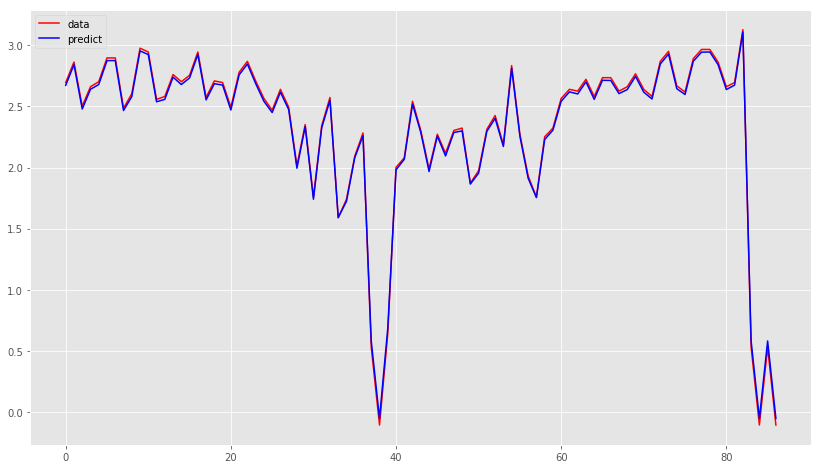

x_scale:  (2, 87, 3, 1)


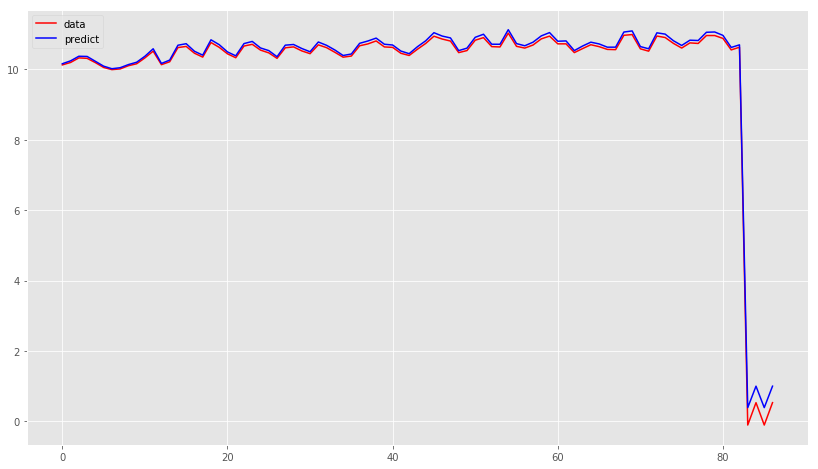

87/87 [==============================] - 1s 8ms/step
model evaluate mse: [1.8026039559265663, 0.14133327959597797, 1.6612706814689198, 0.1413332905577517, 1.6612706376218247]


In [74]:
log_dir = 'model_individual'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )

with timer('train model individual'):
    model.fit(x, x, epochs=400, callbacks=[tensorboard])

window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

# 精度の評価

In [75]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.017414759006381165
rmse: 0.0732443803902204
0.04532956969830078
